# Quantum Simulation of 1D Burgers via Incompressible Hydrodynamic Schrödinger (IHSE) 

<span style="color: orange">Classical fluid dynamics (Navier–Stokes) is notoriously hard to simulate at high Reynolds numbers, due to turbulent cascades across many scales.
Quantum computers can in principle provide exponential speedup for certain problems
The key challenge is that Navier–Stokes is nonlinear and not manifestly Hamiltonian, whereas quantum evolution is inherently linear and unitary.</span>
<br><br><br>

## Problem Statement :

<span style="color: royalblue"> We aim to simulate the **Burgers' equation** on the domain \( x belongs to [0, 1] \) with the following conditions:</span>



 $$ \color{blacck}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$



- <span style="color: orange"> **Boundary Conditions:**  </span>
    - $ u(0, t) = U_L $ left boundary
    - $ u(1, t) = U_R $ right boundary &nbsp;  

- <span style="color: orange">**Initial Condition:** </span>
    - $ u(x, 0) = 1 $  for  $ x < 0.5 $, and $ u(x, 0) = 0 $ otherwise   &nbsp;   &nbsp;  &nbsp;

## Solution

- Meng & Yang (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.033182) show that one can reformulate viscous flow via a hydrodynamic Schrödinger equation (HSE), whose evolution is unitary and thus amenable to quantum simulation.
 
- In this framework, Burgers’ equation (a 1D viscous flow) can be embedded in an incompressible Schrödinger flow (IHSE) by treating the flow as constant-density and encoding velocity in the phase of a complex wavefunction.


### Reformulating Burgers’ Equation via IHSE

The Burgers velocity field $u(x,t)$  is encoded in a Schrödinger-like wavefunction $ \psi(x,t)$ through the Madelung transform. We set the density $|\psi|^2 $ constant (incompressible), so all information lies in the phase $\theta(x,t) = \arg(\psi(x,t))$. 

- In 1D, one chooses $  \psi(x,t) = R*e^{i\, \theta(x, t)} $, where R is equal to one for convinience and then,
$$
\theta(x, t) = \frac{1}{\hbar} \int_{0}^{x} u(\xi, t)\, d\xi
$$

so that $ u(x,t)= ℏ ∂x(\theta(x,t)) $ , which is equivalent to <span style="color: red">(Equation 1)</span>
$$
u(x, t) = \hbar\, \partial_x \left( \arg\big( \psi(x, t) \big) \right)
$$ 

This relation (a form of Eq. 5 in Meng & Yang) means the velocity is recovered from the gradient of the wavefunction phase.The parameter $\hbar$ acts analogously to kinematic viscosity. With constant $|\psi|$, the governing equation becomes the incompressible hydrodynamic Schrödinger equation (IHSE).

## Discretization and Wavefunction Encoding

In [48]:
## Check if all the dependencies are installed
# %pip install qiskit numpy matplotlib scipy  
# %pip install qiskit-ibm-runtime qiskit-aer qiskit-ignis qiskit-visualization    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.circuit.library import DiagonalGate



ħ = 0.010             # Planck constant as the viscosity for the fluid flow
nq = 5                # Number of qubits for sampling
N = 2 ** nq          # Lattice size (grid points)
dx = 1.0 / N            # Spatial step (over [0, 1])
dt_int = 0.1        # Internal Trotter step
T_end = 4.0             # End time
save_dt = 0.20       # Saving interval for plots

We discretize the spatial domain $x\in[0,1]$ into $N=2^n$ uniform grid points ($N$ is a power of two for $n$ qubits). Each basis state 
$|j\rangle$ represents location $x_j=j\Delta x$ with $\Delta x=1/\N$. The wavefunction is stored as a statevector on $n$ qubits:
$$
|\psi\rangle = \sum_{j=0}^{N-1} \psi_j\, |j\rangle,\qquad \psi_j = e^{i \theta_j}
$$
From <span style="color: red">(Equation 1)</span>, we can discretize integral to sum as
$$
\theta_j = \frac{1}{\hbar} \sum_{k < j} u_k\,\Delta x
$$

We fix $|\psi_j|=1$ (unit density), so all dynamics are in the phase. In practice one normalizes $|\psi\rangle$ to unit norm, which multiplies all amplitudes by a constant factor. 
 -  The Euler form of the wavefunction is then $\psi_j = R_j e^{i\theta_j}$ with $R_j\approx1$; the velocity is $u_j = \hbar(\theta_{j+1}-\theta_j)/\Delta x$. This mapping (Madelung transform) encodes the Burgers initial condition $u(x,0)$ into the initial quantum state $|\psi(0)\rangle$.

## Initialised vector states


In [50]:
x = np.arange(N) * dx
u0 = np.where(x <= 0.5, 1.0, 0.0)      # Riemann step initial velocity
θ = np.cumsum(u0) * dx                 # θ_j = ∑ u Δx ,the state wavefunction is in Euler form
psi0 = np.exp(1j * θ / ħ)   # Initial wavefunction |ψ(0)>
psi0 /= np.linalg.norm(psi0)
# Some random variables for the simulation
b = psi0.copy() 
a = psi0.copy() 

In this formulation the Hamiltonian is real and Hermitian:

$$
H=T+WLLF 
$$,
where $T = -\frac{\hbar^2}{2}\partial_x^2$ is the kinetic operator and $W_{LLF}(x)$ is a nonlinear potential arising from density gradients (the Landau–Lifshitz force term). <br >Meng & Yang show that for constant density this Hamiltonian is Hermitian (Equation 31, in the referrence paper), ensuring unitary evolution.
Thus one obtains a unitary evolution $|\psi(t+\Delta t)\rangle = e^{-iH\Delta t/\hbar}|\psi(0)\rangle$ that encodes Burgers flow.

---

### Trotterized Hamiltonian Evolution


We split the Hamiltonian into kinetic and potential parts: $H = T + W_{LLF}$, with $T=-\frac{\hbar^2}{2}\partial_x^2$ and $W_{LLF}(x)$ a nonlinear position-space potential (arising from $-(\hbar^2/8)|\nabla\ln|\psi|^2|^2$ for variable density). Time-evolution $e^{-iH\Delta t/\hbar}$ is implemented by a second-order Trotter decomposition.
For example, one uses
assuming $[T,W_{LLF}]\neq0$. 

In our implementation, we alternate the kinetic and potential evolutions at each time step $\Delta t$.

- Kinetic term ($T$): Diagonal in momentum basis. We implement this by applying the Quantum Fourier Transform (QFT) to $|\psi\rangle$, which maps position states to discrete momentum states. In momentum basis each component $k$ acquires a phase $e^{-i(\hbar^2k^2/2)\Delta t/\hbar} = e^{-i(\hbar k^2/2)\Delta t}$. Equivalently, one applies a diagonal phase gate $\exp(-i \frac{\hbar k^2}{2}\Delta t)$ to each momentum basis state. Then an inverse QFT returns to the position basis. This implements $\exp(-iT\Delta t/\hbar)$ efficiently (QFT provides exponential speedup over a classical FFT).

- Nonlinear potential (LLF) term ($W_{LLF}$): Diagonal in position basis. We compute the instantaneous density $\rho_j=|\psi_j|^2$ and approximate the LLF potential (for constant nominal density) as $W_{LLF}\propto -\tfrac{\hbar^2}{8}(\nabla_x\rho_j)^2$, take $\rho_j= s $. In practice one discretizes $(\partial_x s)^2$. We then apply a diagonal unitary $\exp(-iW_{LLF}\Delta t/\hbar)$ to each position basis state. For our constant-amplitude setup, this term is typically zero or small.

These pieces are composed according to the Trotter formula. Thus one full time step $\Delta t$ involves alternating QFT-based kinetic phases and position-space potential phases, as sketched in Fig.1 of Meng & Yang.

## KINetic Energy Term for the ISF , the schrodinger flow 
- we adapt using QFT and IQFT to solve this 

In [51]:
momentum = 2 * np.pi * np.fft.fftfreq(N, dx)  # FFT momenta
def qft_circ(n):
    qc = QuantumCircuit(n)
    for j in range(n):
        qc.h(j)
        for k in range(j + 1, n):
            qc.cp(2 * np.pi / (2 ** (k - j + 1)), k, j)
    for i in range(n // 2):
        qc.swap(i, n - 1 - i)
    return qc

IQFT = qft_circ(nq).inverse()    

## Apply trotterised evolution

We apply the Trotterisation for time step dt_int and evolve the Discretised Coefficients which represents the wavefunction to get a statevector that can be extracted to get the velocity of the Fluid system in the end.
$$

e^{-iH\Delta t / \hbar} \approx e^{-i T (\Delta t / 2) / \hbar} \, e^{-i W \text{LLF} \, \Delta t / \hbar} \, e^{-i T (\Delta t / 2) / \hbar}

$$

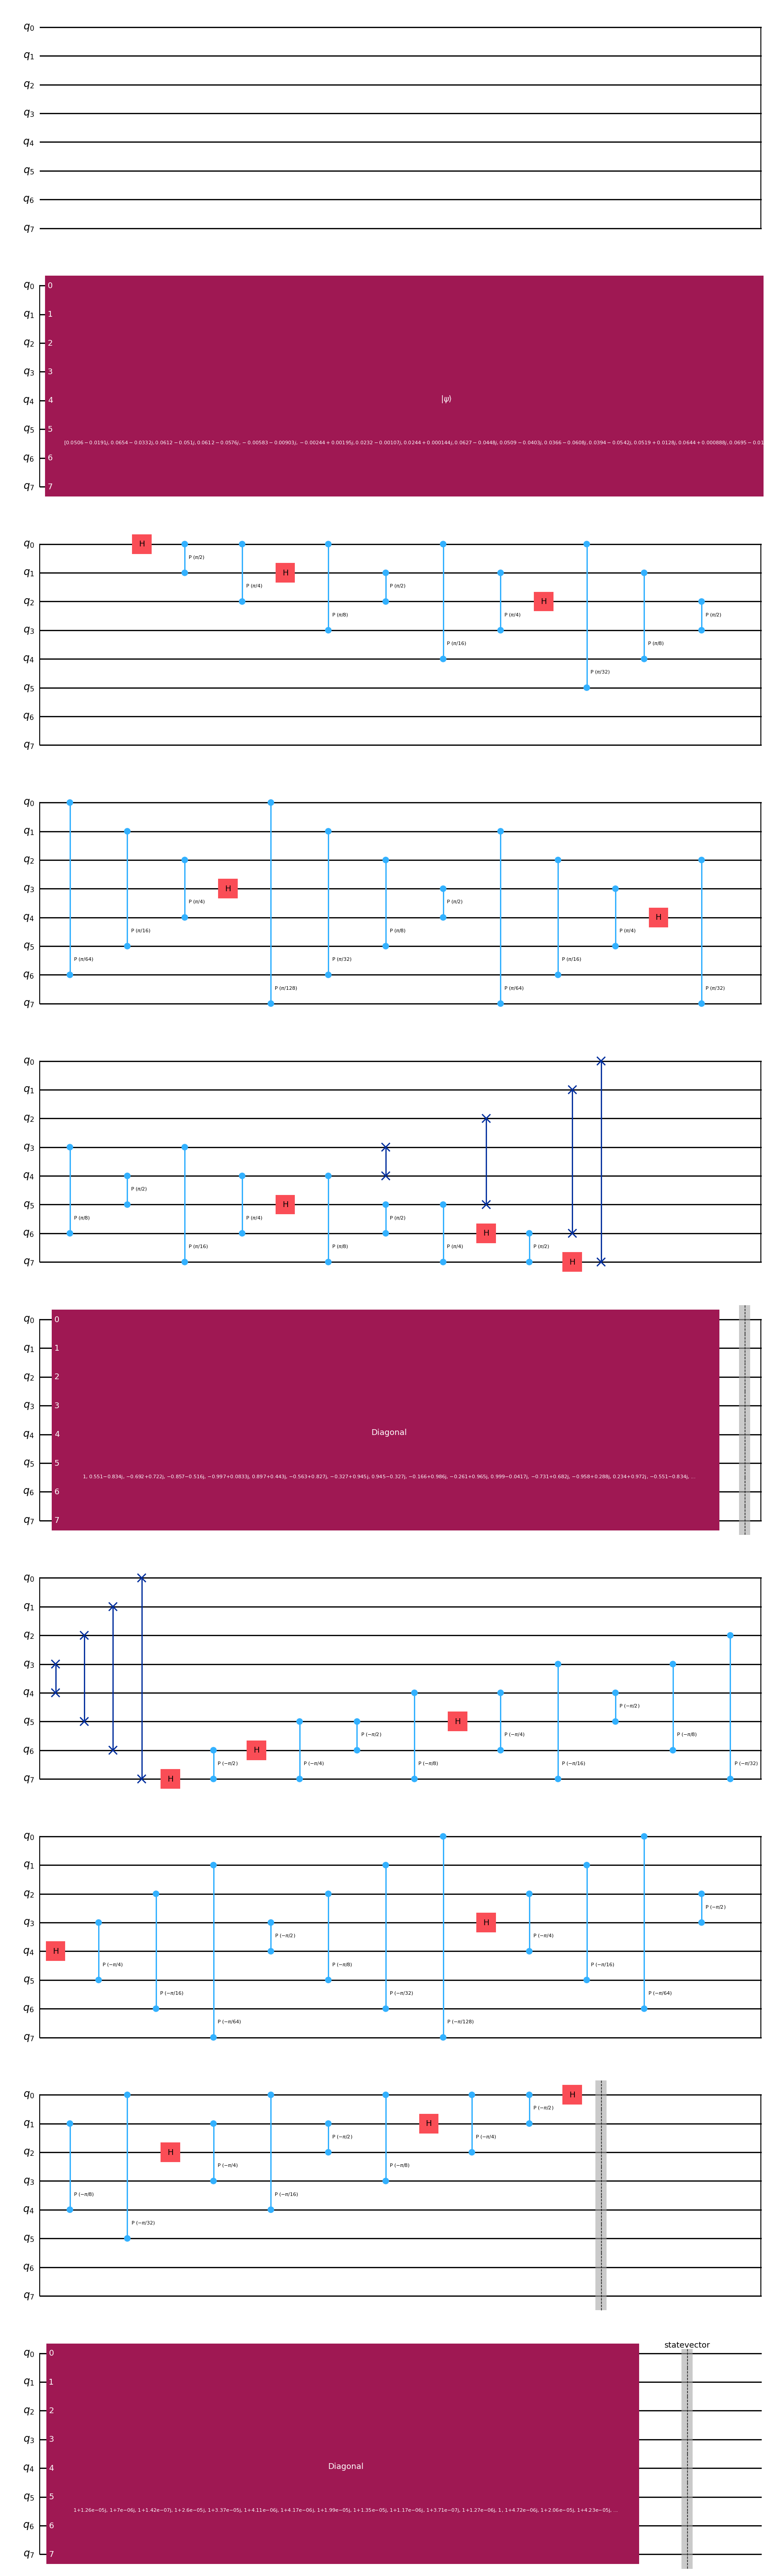

In [ ]:
from scipy.ndimage import gaussian_filter1d

backend = AerSimulator(method='statevector')
save_times = [0.0]
save_vels = [u0.copy()]
current_t = 0.0

window_length = 7         # must be odd
polyorder = 2

while current_t < T_end:
    b = a
    qc = QuantumCircuit(nq)
    #####################################
    # preparing  state
    qc.initialize(b, range(nq))
    qc.compose(qft_circ(nq), inplace=True) # Quantum Fourier Transform
    phaselist = np.exp(-1j * 0.5 * momentum ** 2 * (dt_int/2))
    
    diag_gate = DiagonalGate(phaselist) # Diagonal gate for momentum phase
    qc.append(diag_gate, range(nq))
    qc.barrier()
    qc.compose(IQFT, inplace=True) # Inverse Quantum Fourier Transform
    qc.barrier()
    #####################################
    s = np.abs(b)**2 # s(x) = s=|ψ∗ψ|=a^2+b^2, taking the b because finding the spinor for previous state
    s_smooth = gaussian_filter1d(s, sigma=1.0, mode='reflect')
    ds = np.gradient(s_smooth, dx, edge_order=2)
    V_NL = -((ħ ** 2) / 8) * (ds ** 2 )     # Nonlinear potential array
# Applying diagonal phase for nonlinear potential (efficient)
    phases = np.exp(-1j * V_NL * dt_int / ħ)
    qc.append(DiagonalGate(phases), range(nq))
    # save the statevector
    qc.save_statevector()

    # propagate statevector
    
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc,  shots=1024, memory=True).result()
    statevector = result.get_statevector(qc)
    a = statevector.copy()
    # end of propagation  
    # Updating the time to plot for various 
    current_t += dt_int
    if abs(current_t - save_times[-1] - save_dt) < dt_int:
        phase = np.unwrap(np.angle(a).data)
        phase_smooth = gaussian_filter1d(phase, sigma=1.0, mode='reflect') 
        vel = np.gradient(phase_smooth, dx, edge_order=1)*ħ
        save_times.append(round(current_t, 3))
        save_vels.append(np.abs(vel))
qc.draw('mpl')  # Draw the quantum circuit

## Classical vs Quantum Simulation: Cole-Hopf and ISF Approaches

### Classical Solution: Cole-Hopf Transformation

The **simulate_burgers_cole_hopf** function numerically solves the 1D viscous Burgers' equation using the Cole-Hopf transformation, which linearizes the nonlinear PDE into a heat equation. This enables stable and efficient simulation via classical methods.
The function returns the spatial grid, snapshot times, and the velocity field history for direct comparison with quantum simulation results.

---

### Quantum Solution: IHSE (Incompressible Hydrodynamic Schrödinger Equation)

The quantum simulation reformulates Burgers' equation as a unitary evolution using the IHSE, encoding the velocity field in the phase of a quantum wavefunction. This approach leverages quantum circuits for efficient simulation of fluid dynamics.


### Comparison

Both methods produce velocity profiles at matching time snapshots, enabling direct benchmarking of quantum and classical approaches for simulating nonlinear fluid dynamics.

L2 error at different times  [0.04950738 0.63982562 0.79119758 0.84206744 0.90600326 0.82639946
 0.96704212 1.74925754 2.28768592 2.73384994 3.19211642 3.518908
 3.81791805 4.24865311 4.50467108 4.73631387 5.05988428 5.24538446
 5.39031976 5.66352162 5.89367491 5.99733764 6.18021651 6.36113454
 6.4638915  6.59398665]


/tmp/ipykernel_87063/3743770478.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 7))


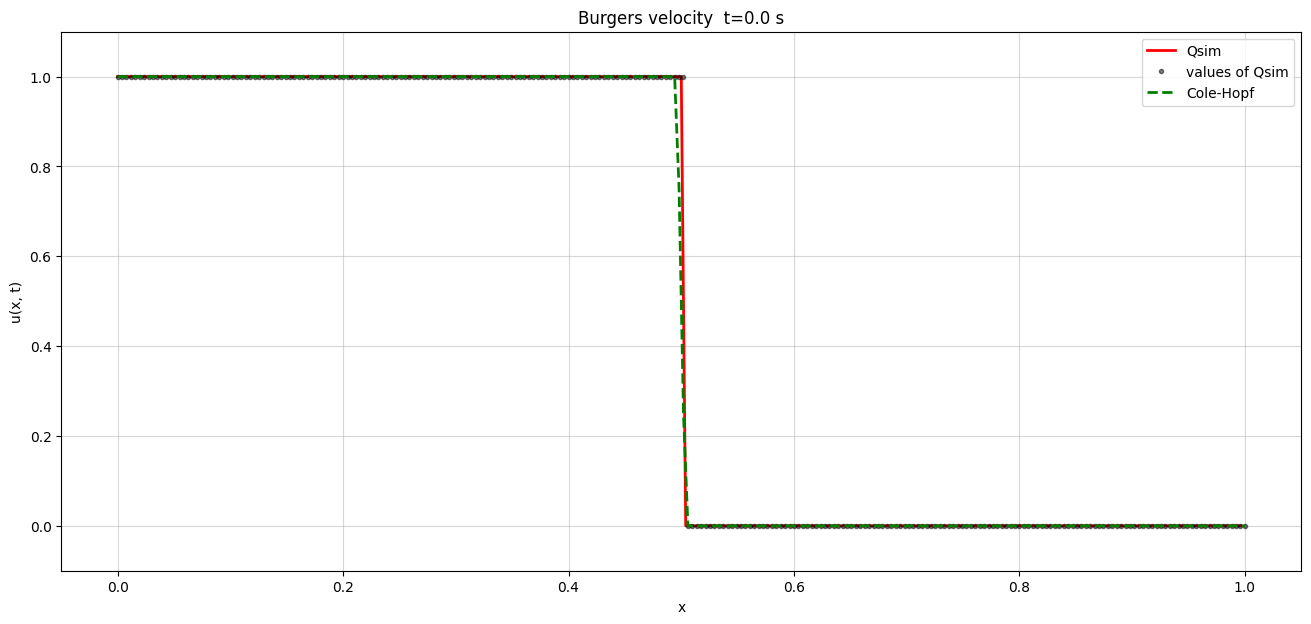

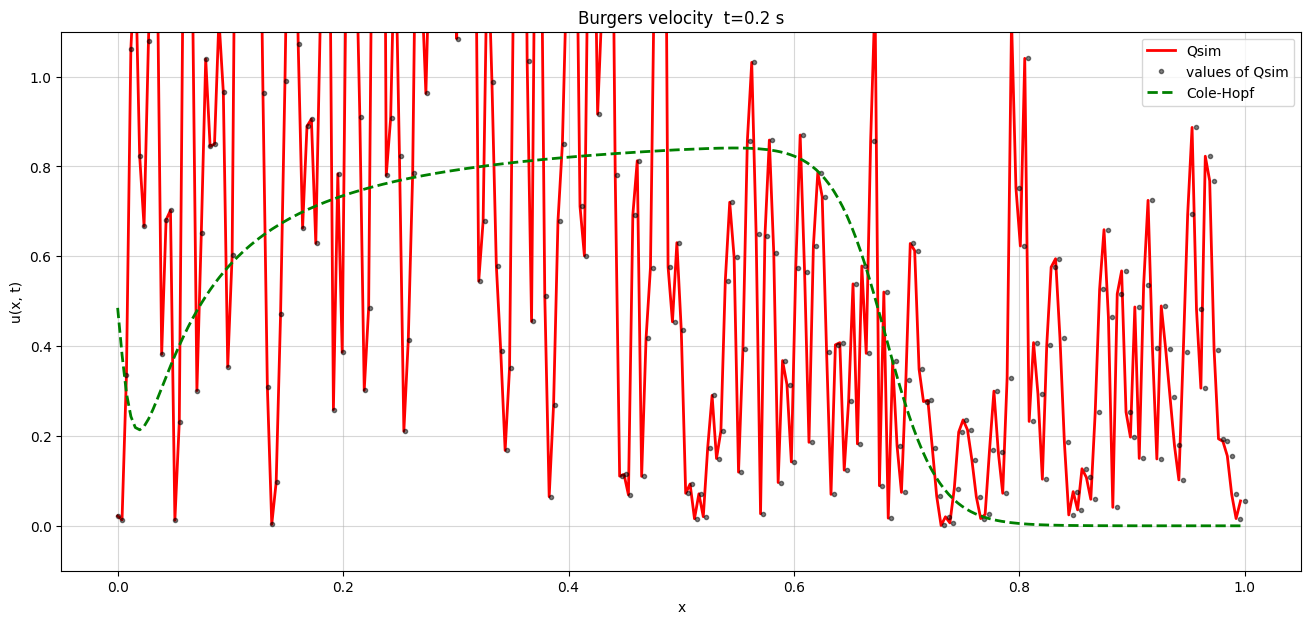

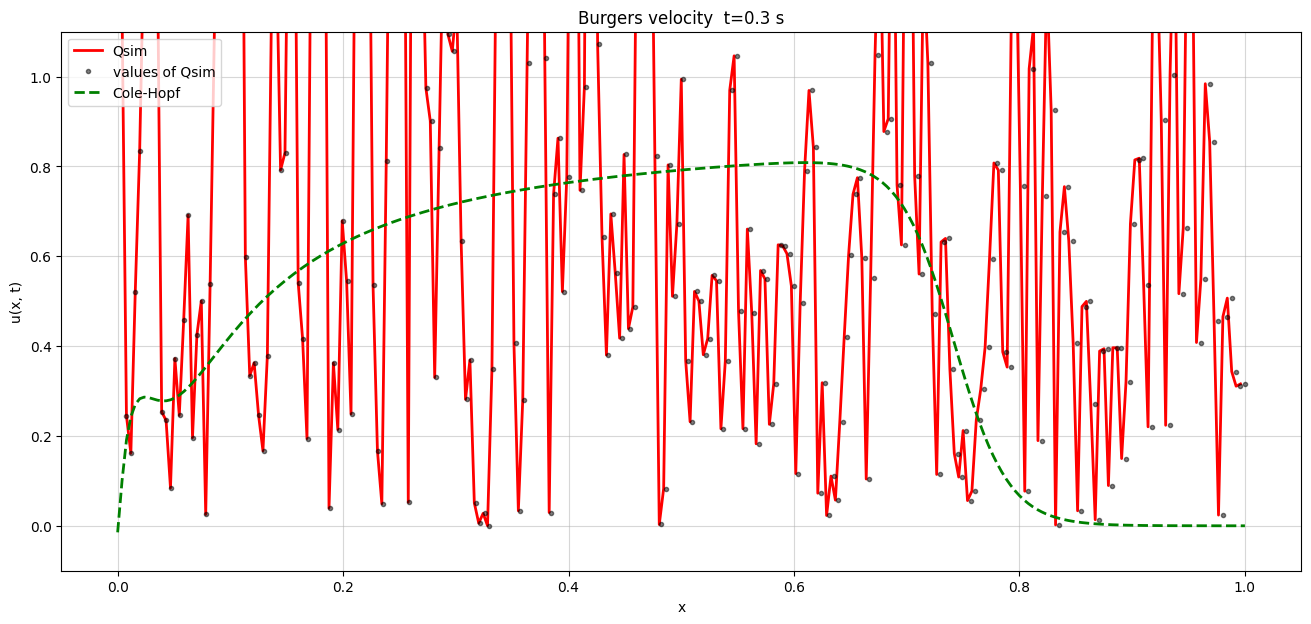

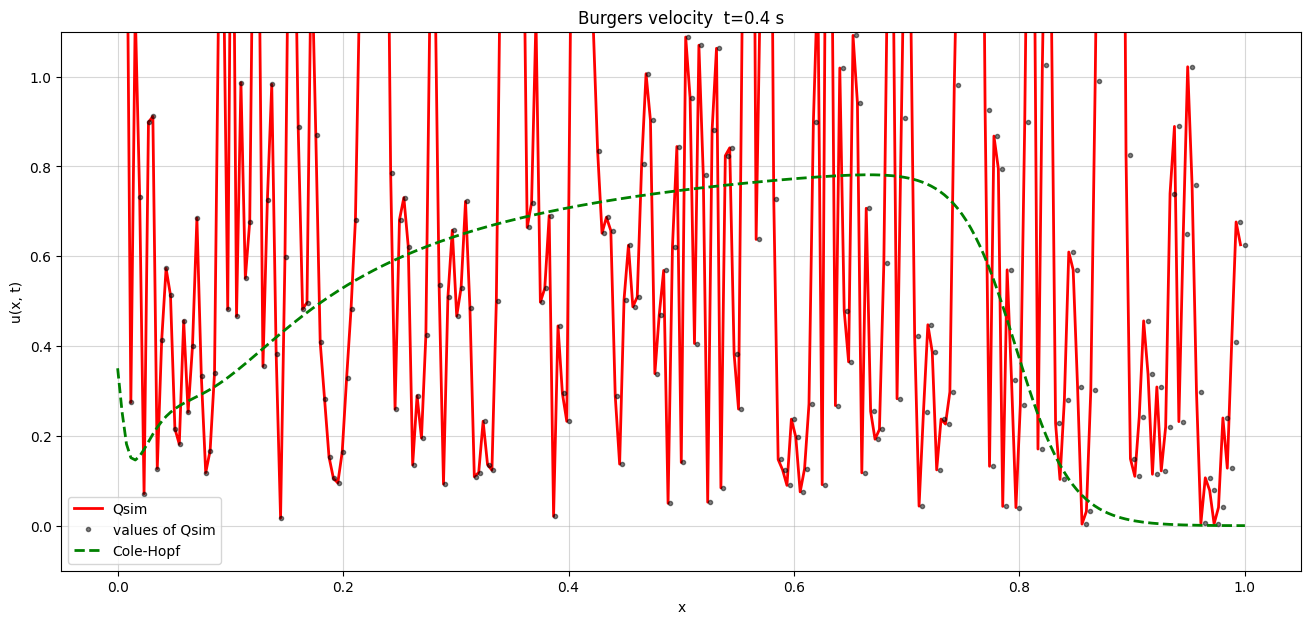

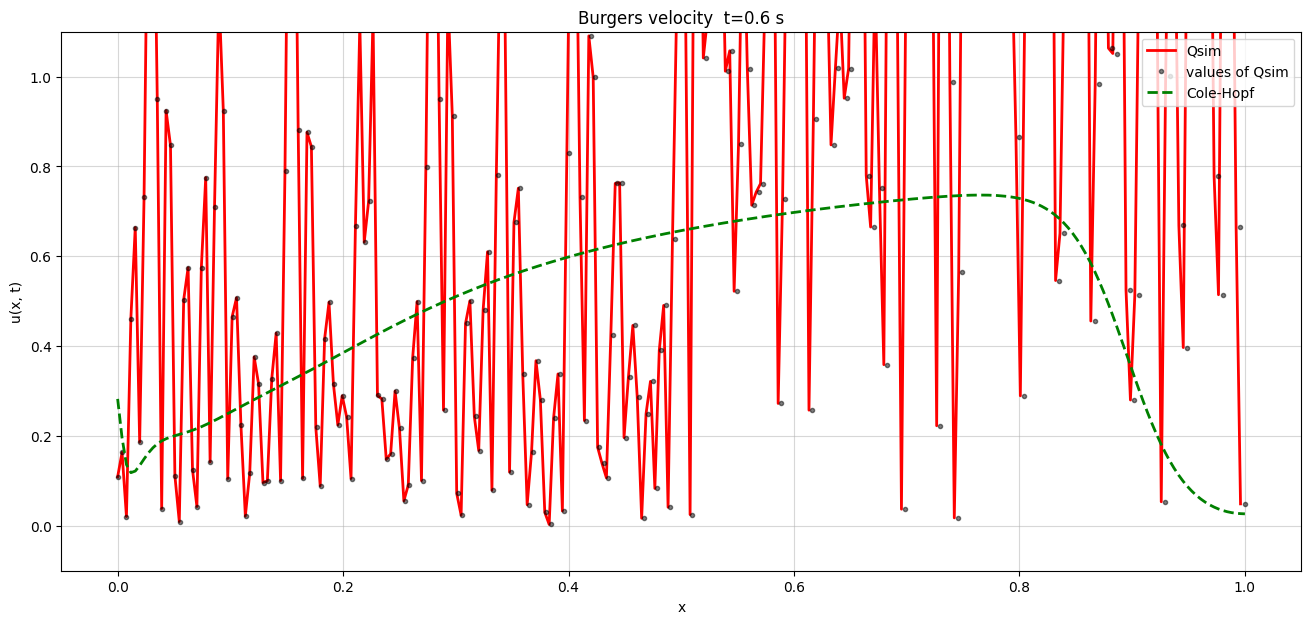

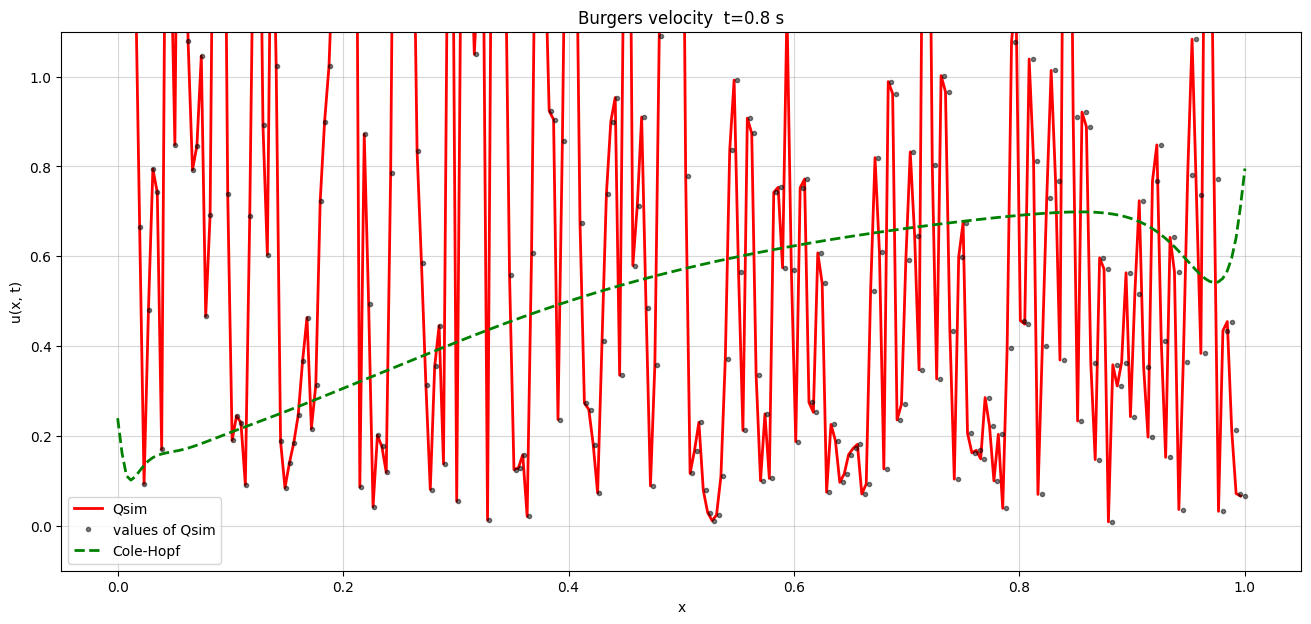

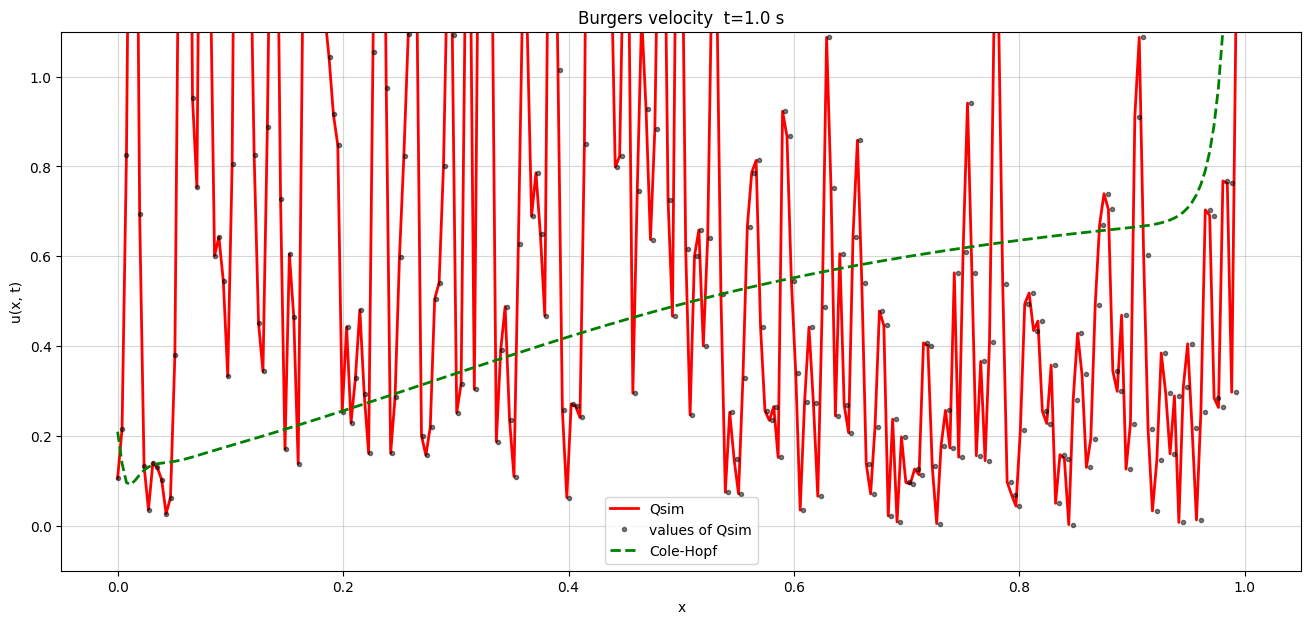

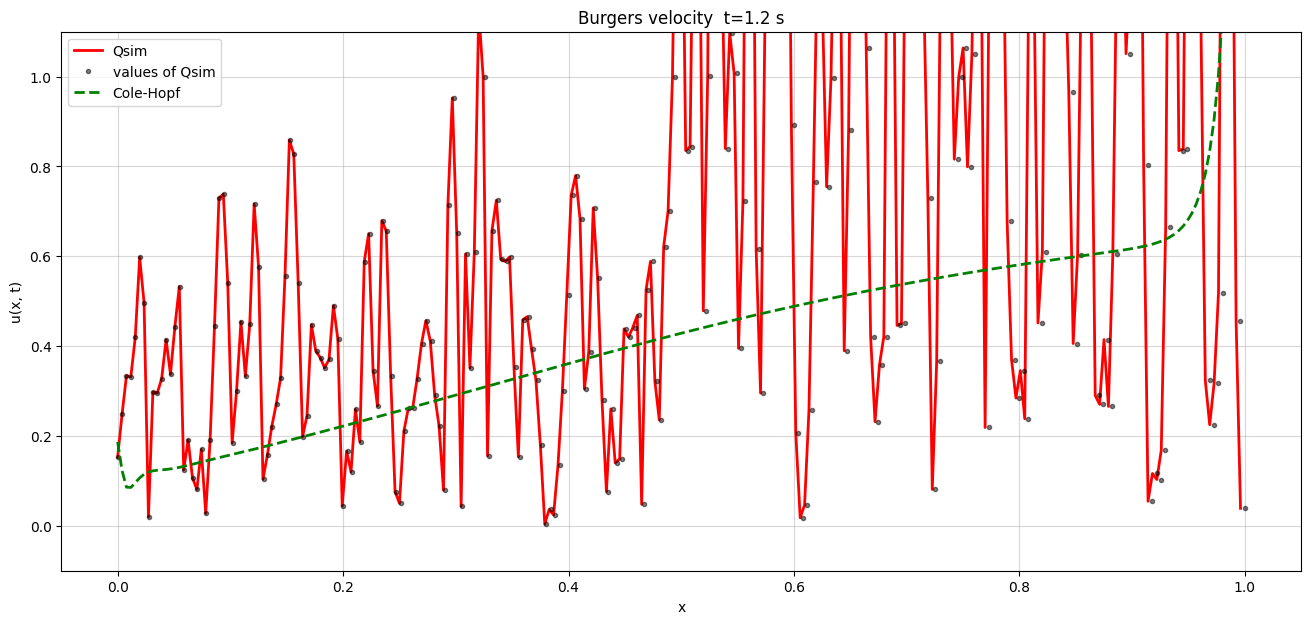

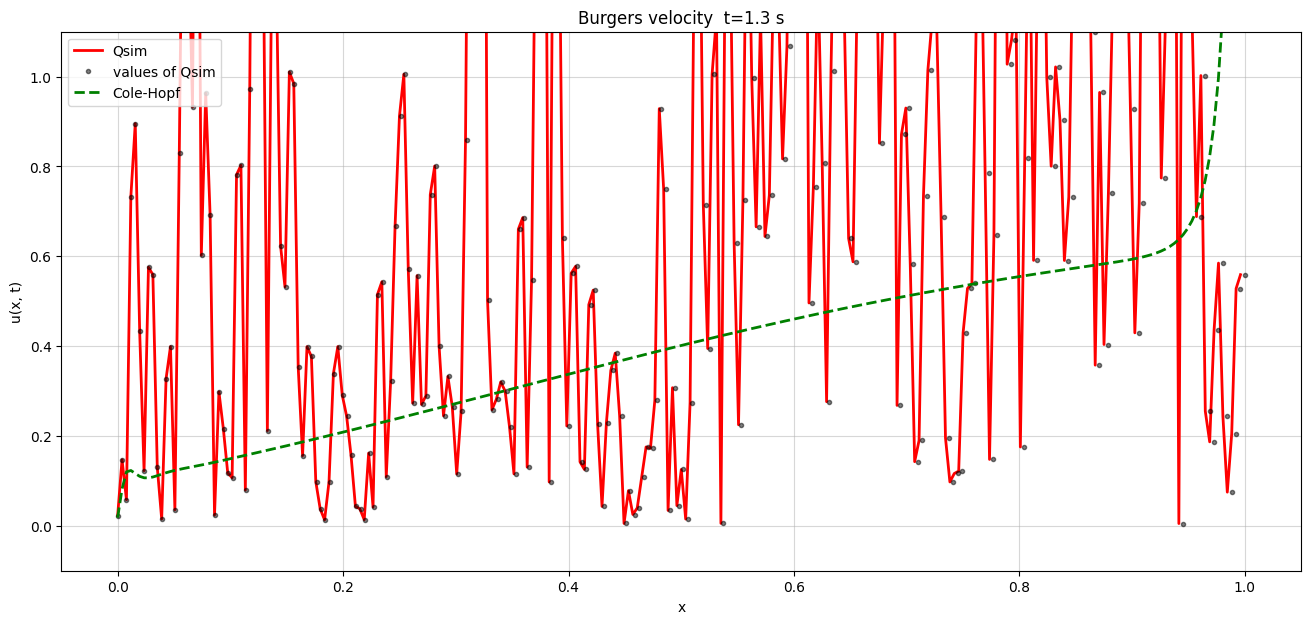

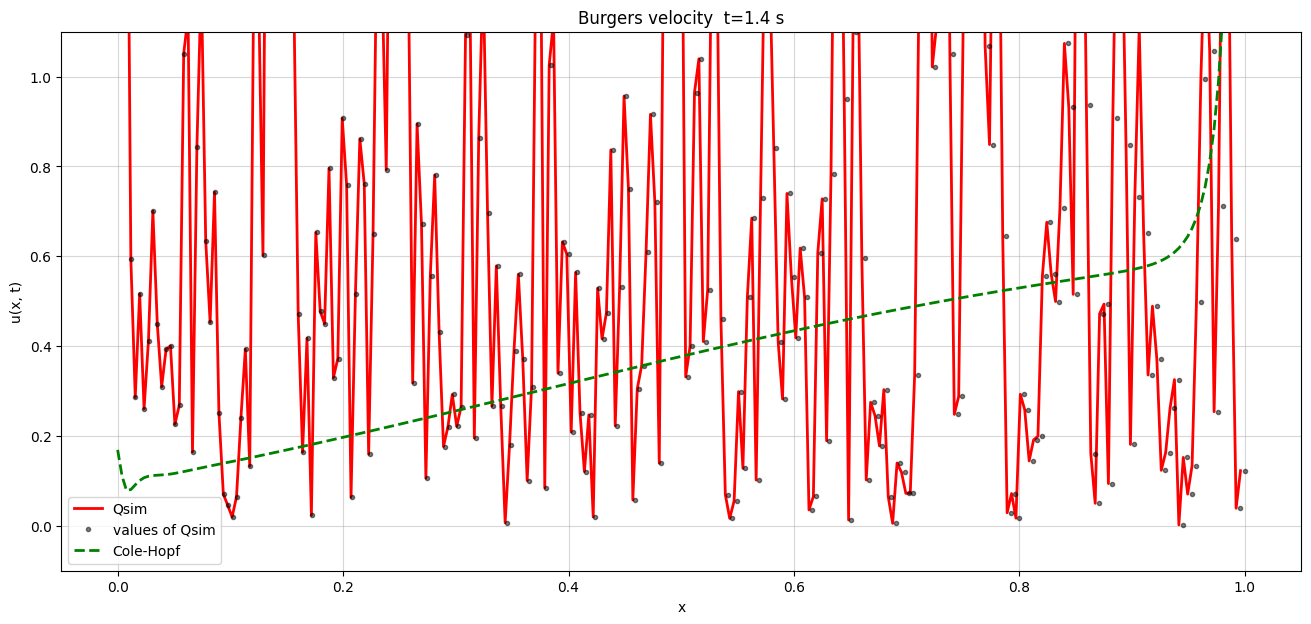

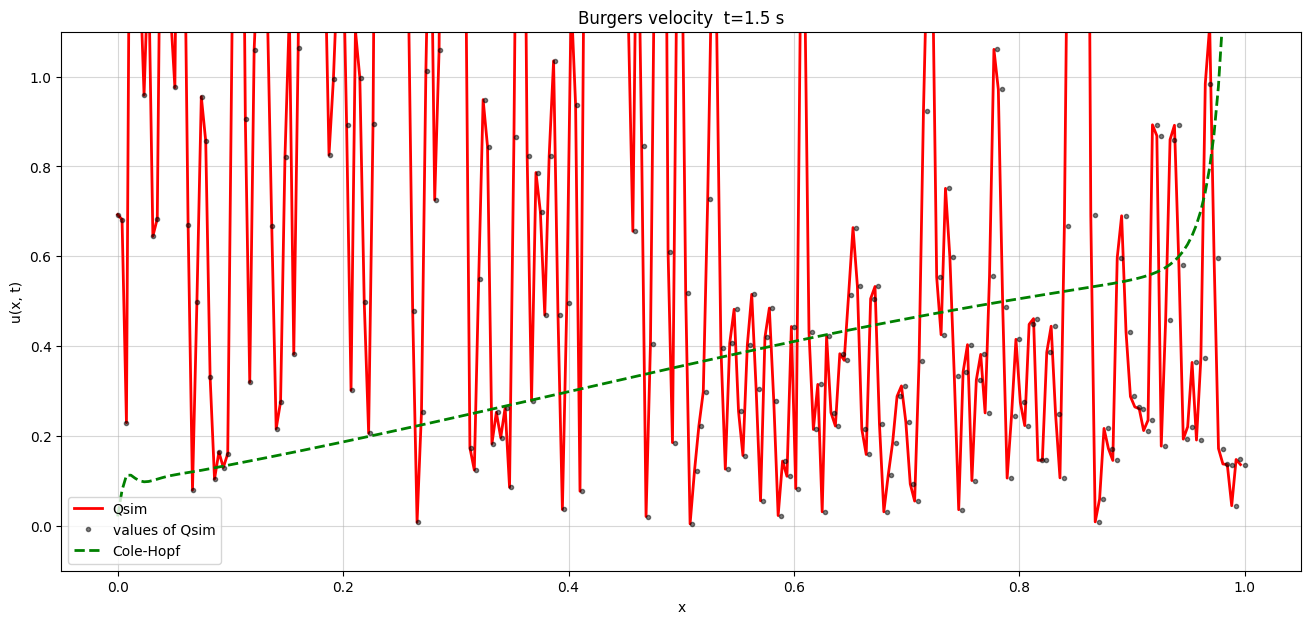

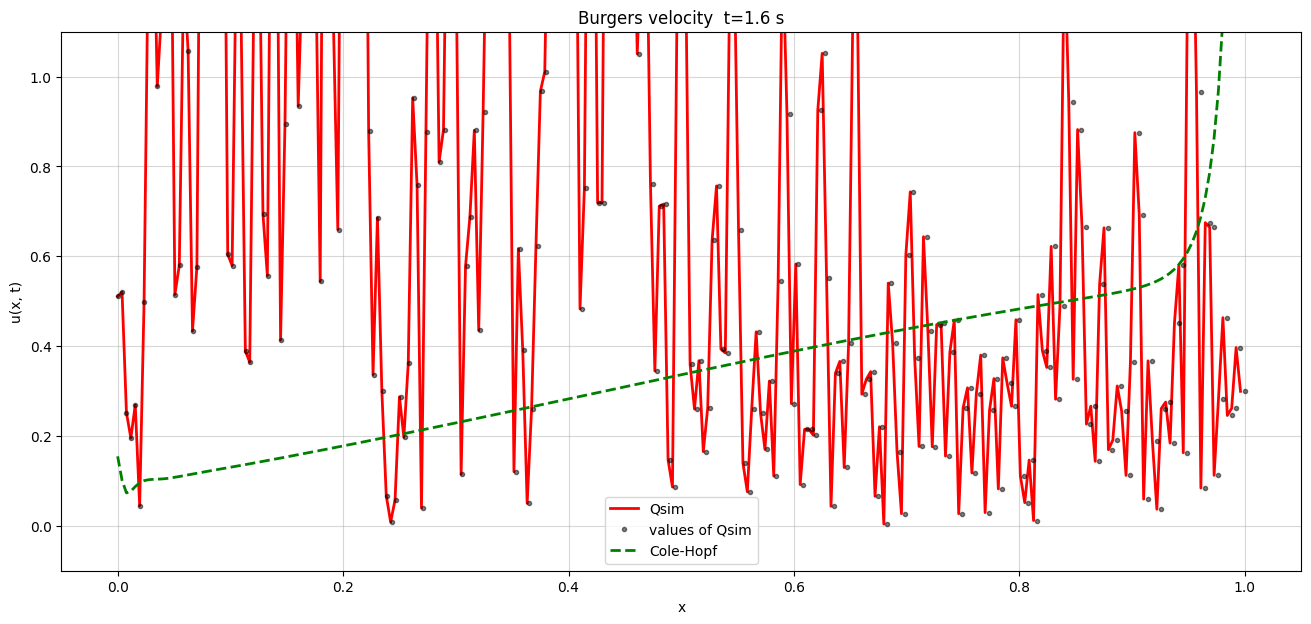

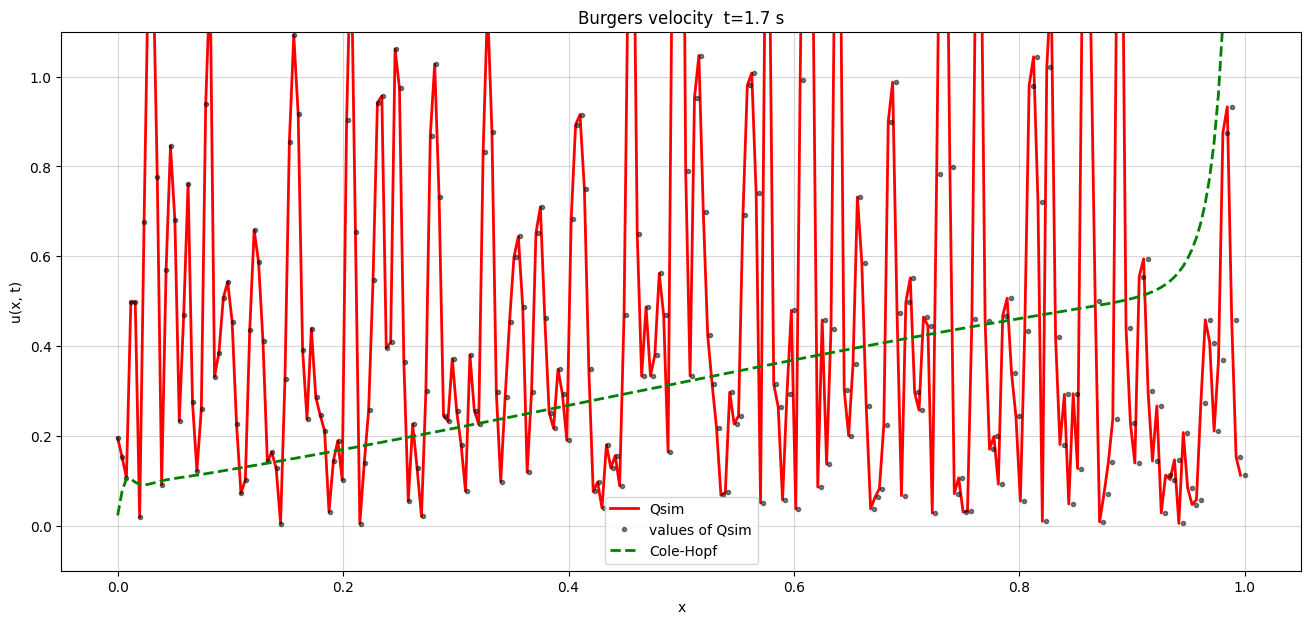

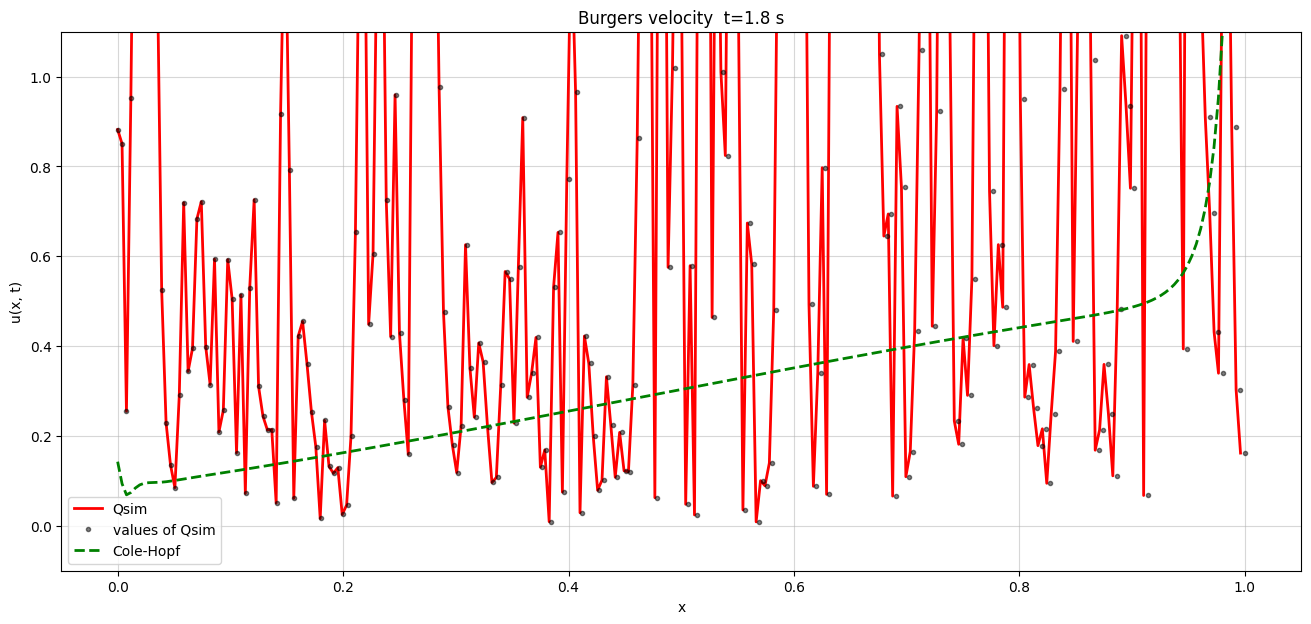

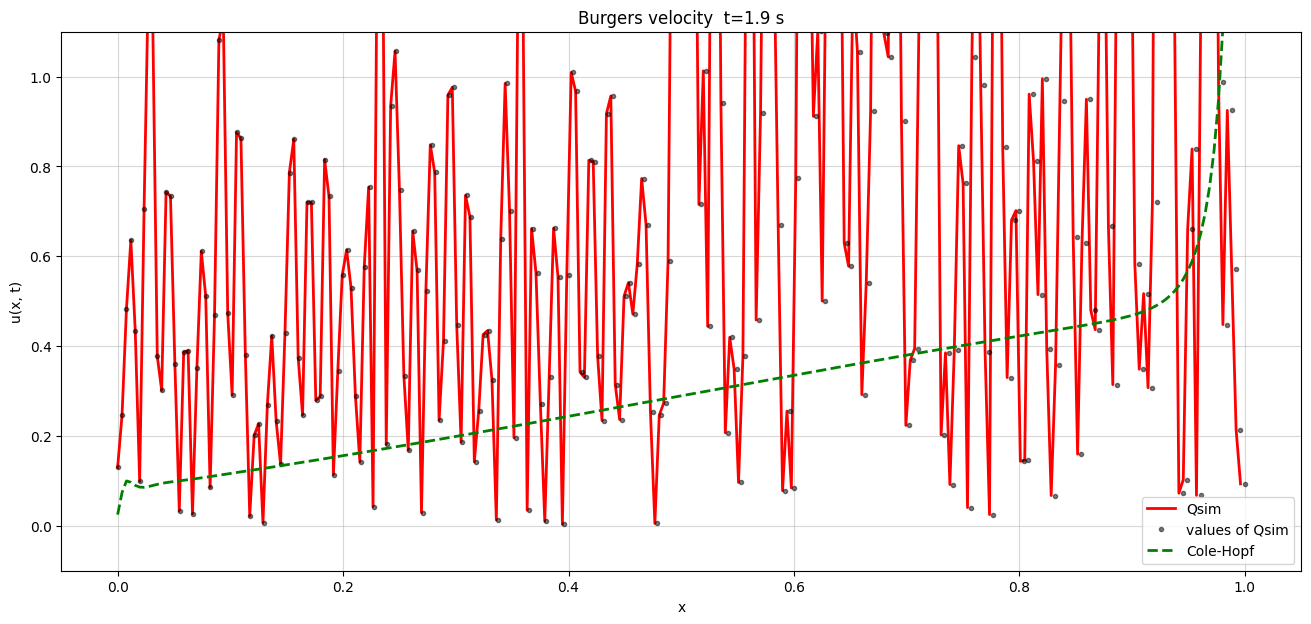

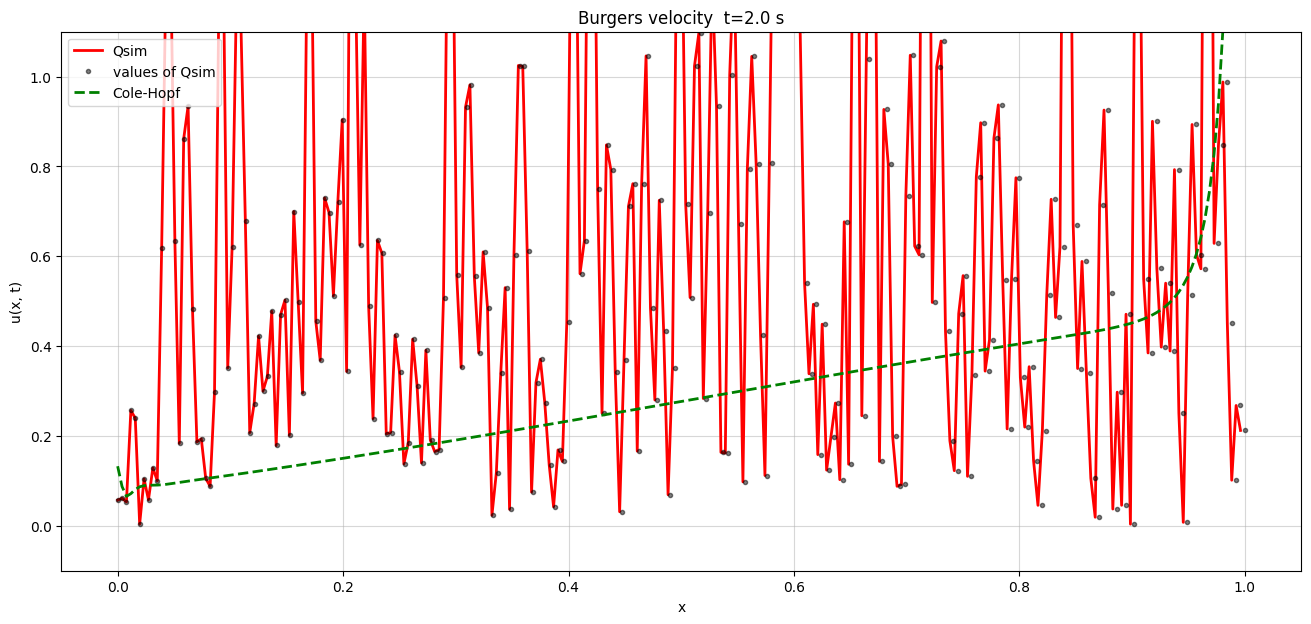

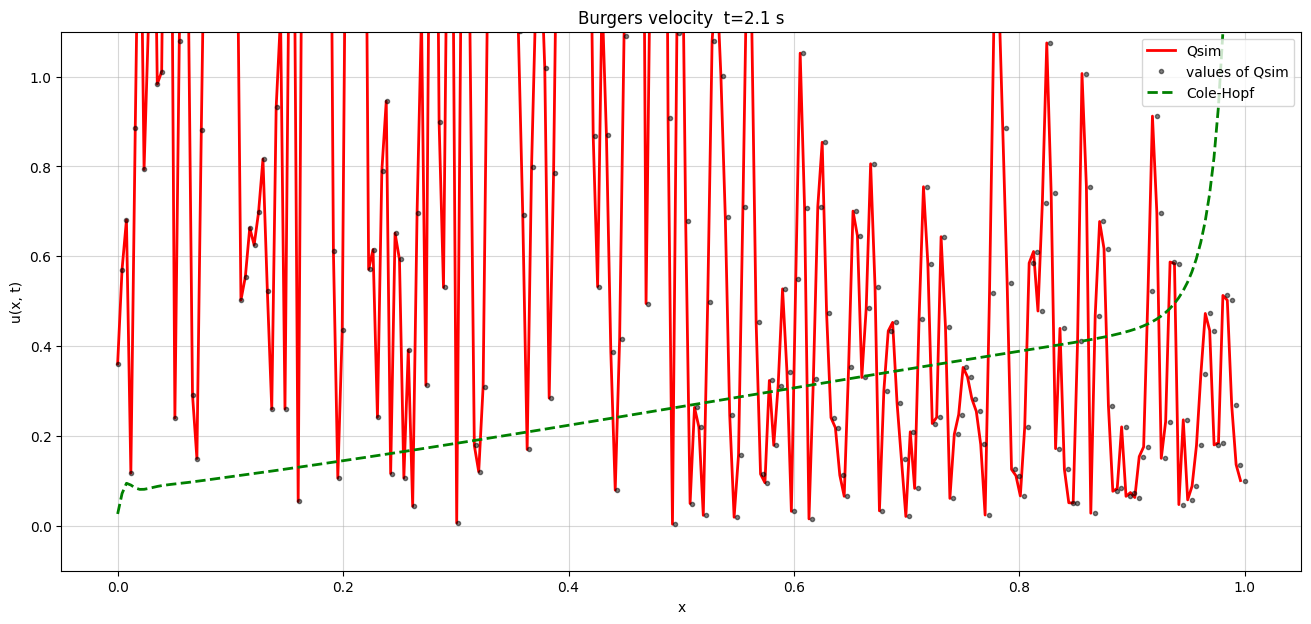

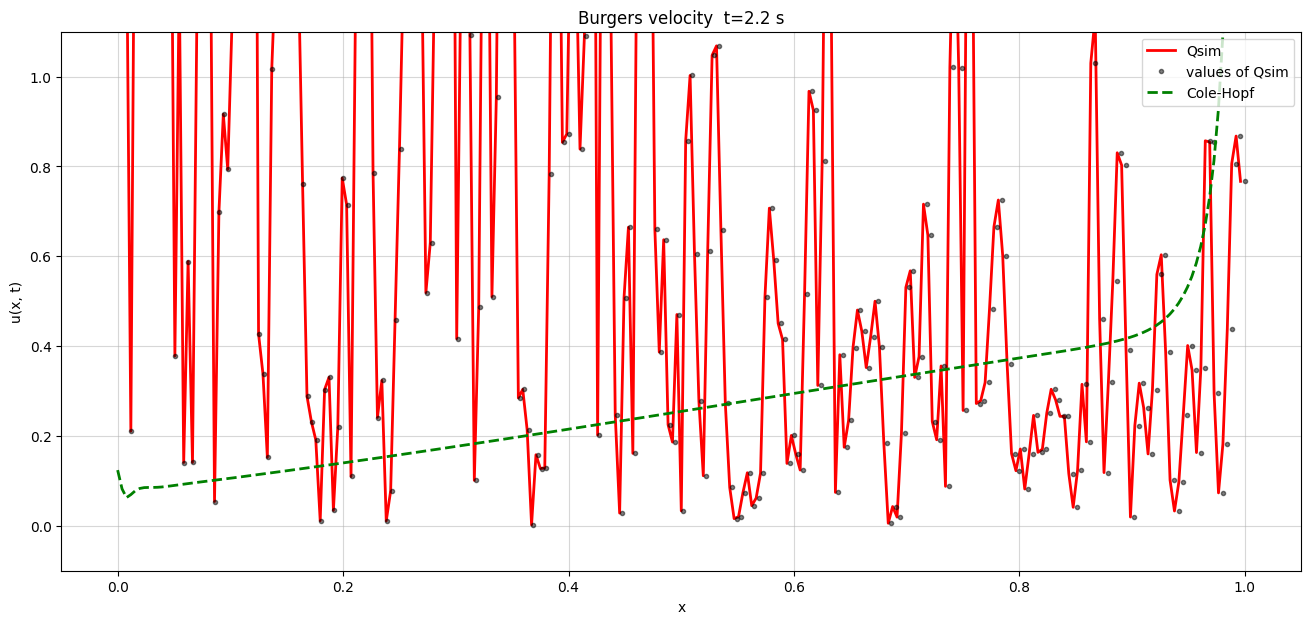

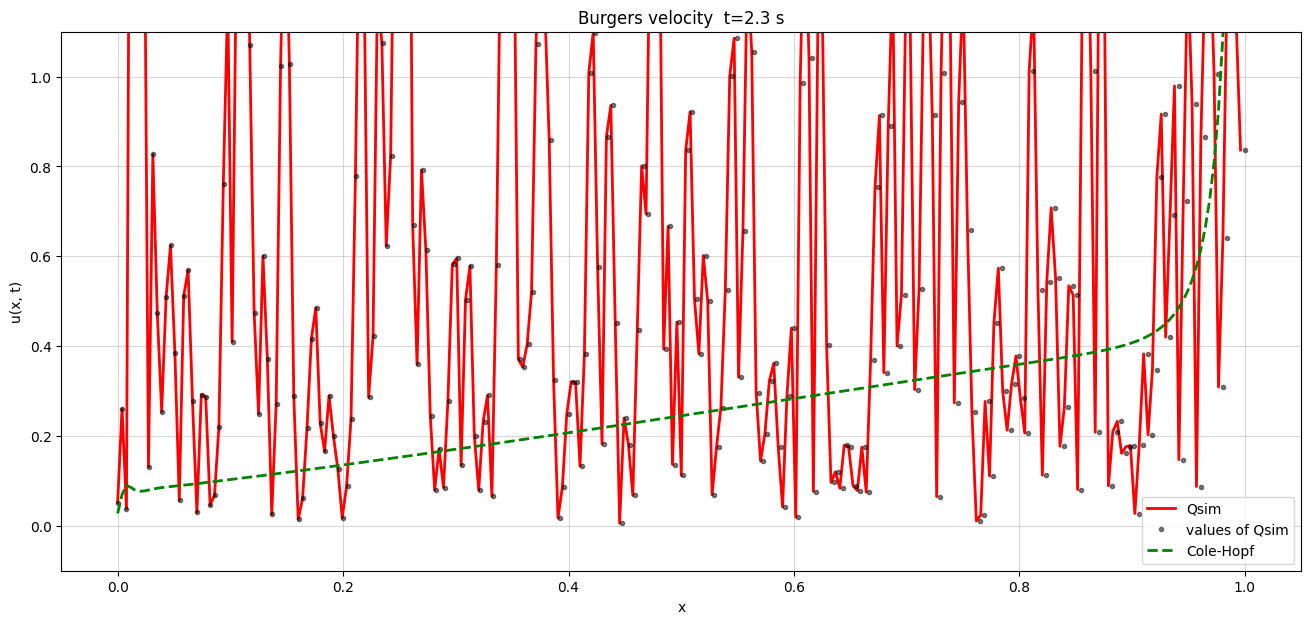

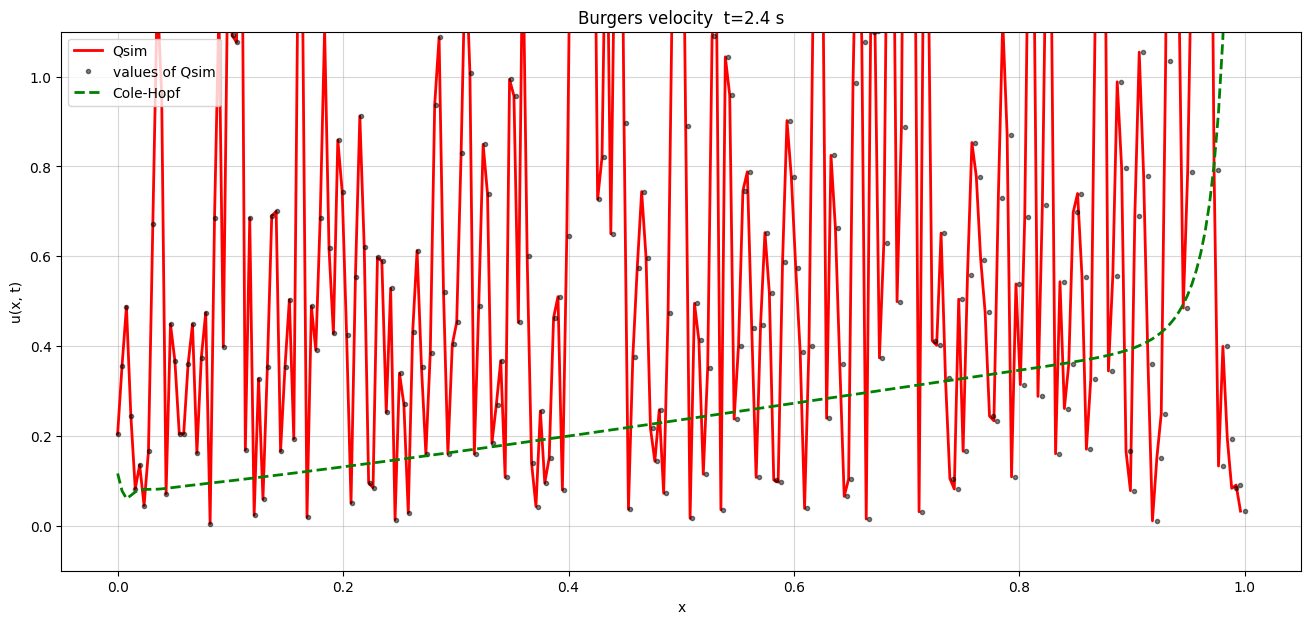

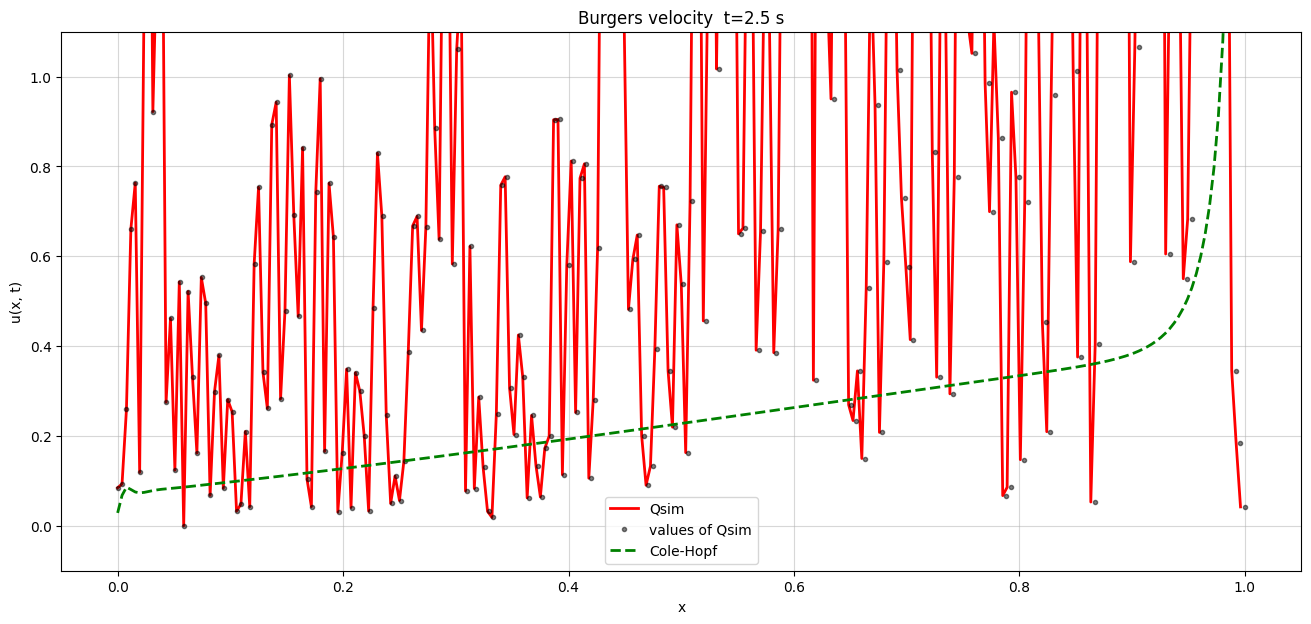

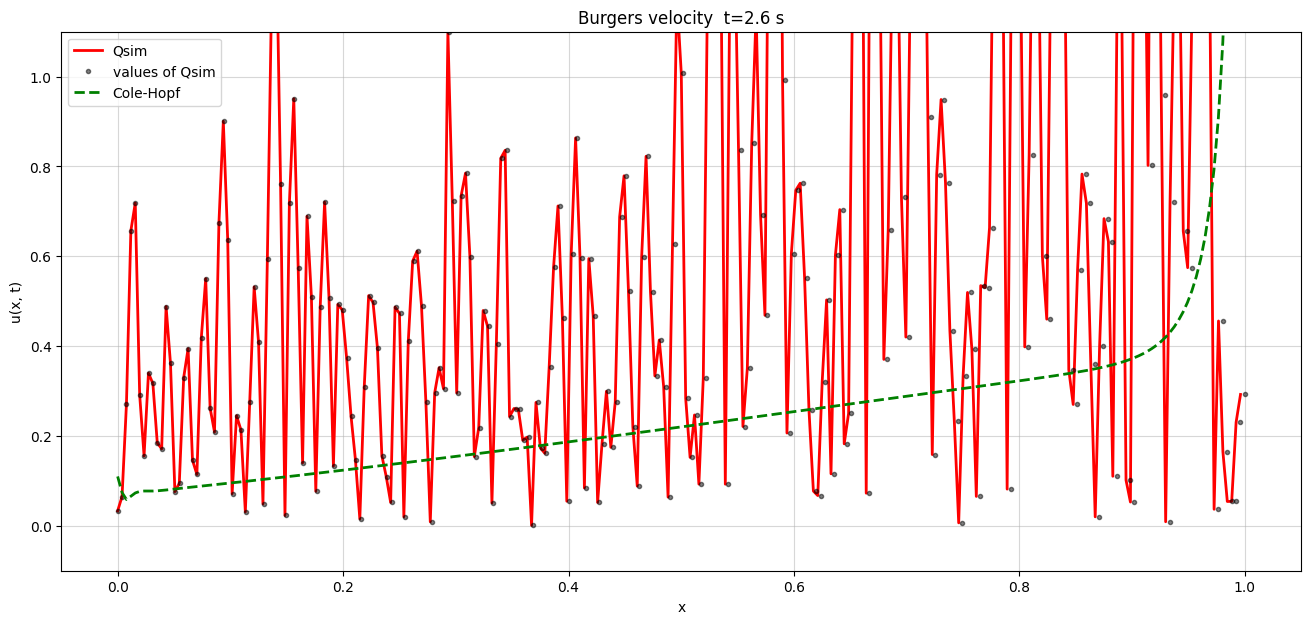

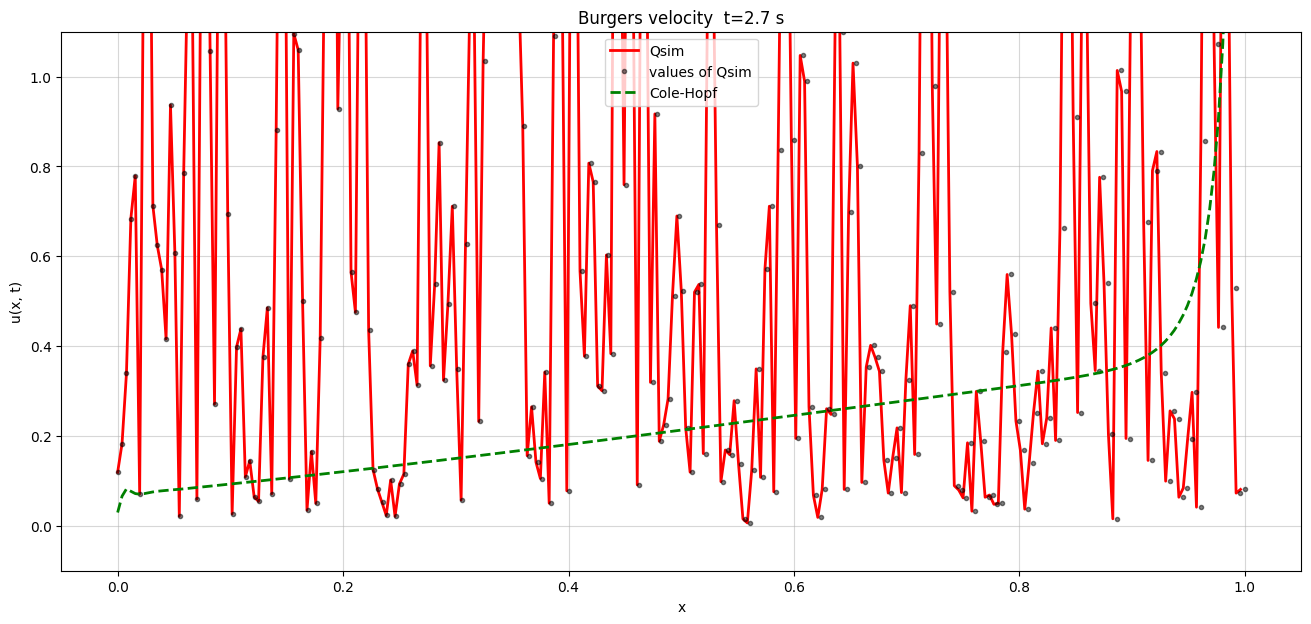

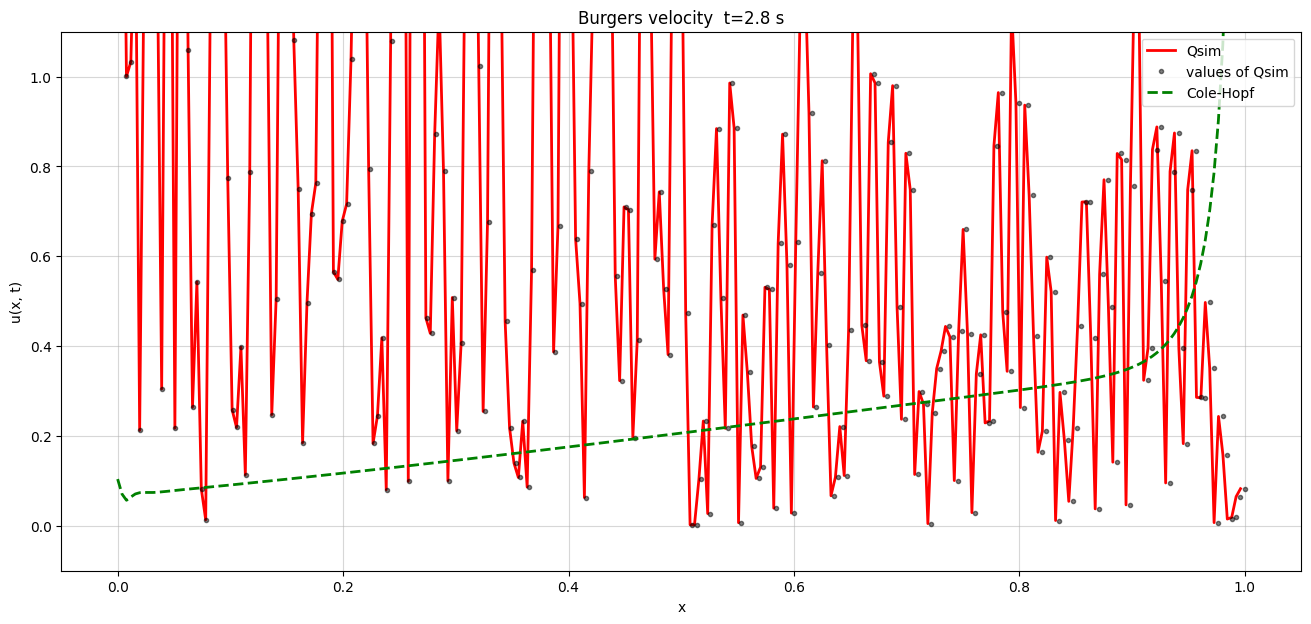

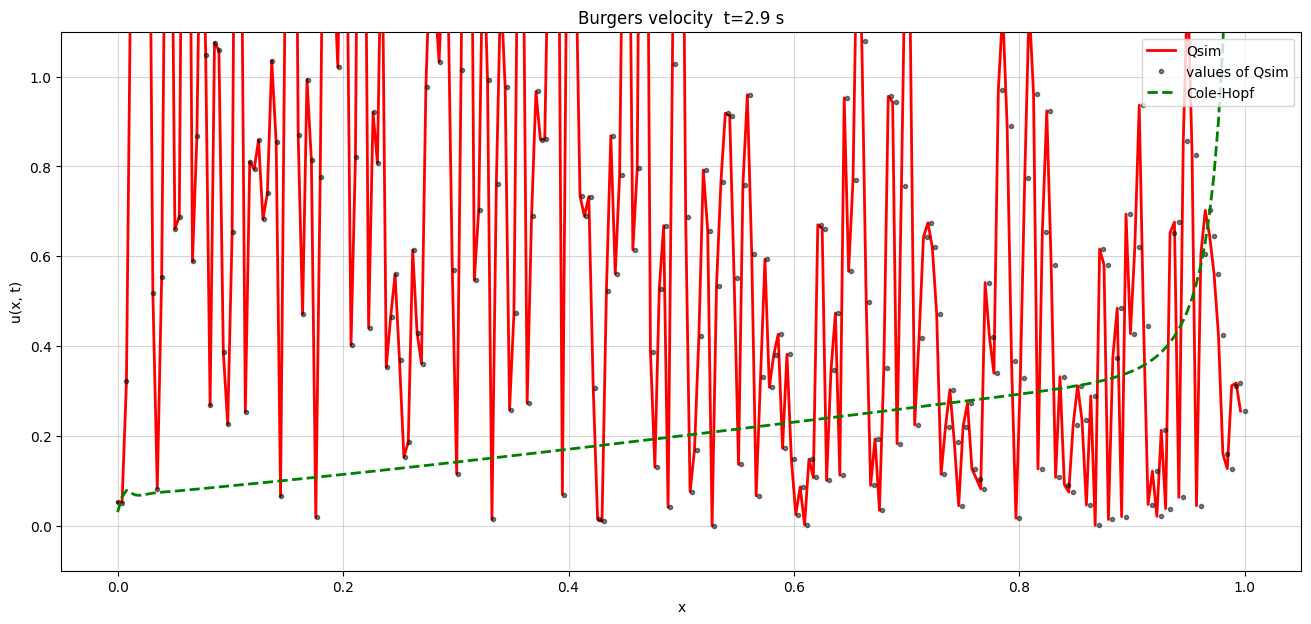

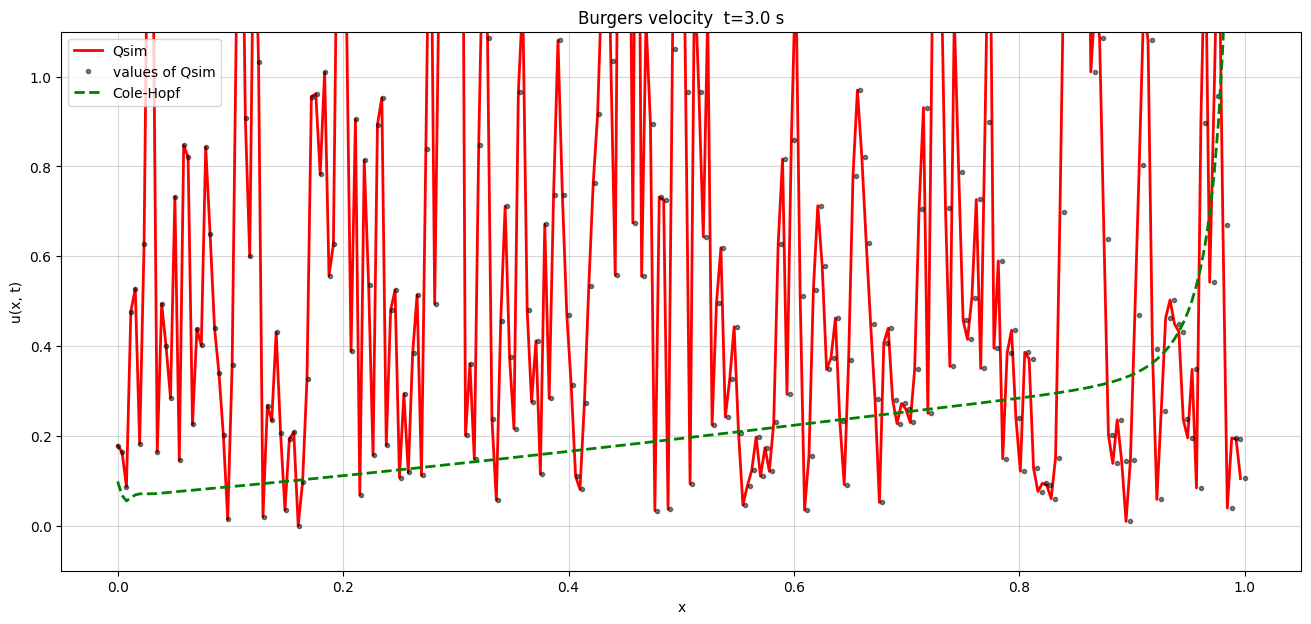

In [61]:
from Plot import simulate_burgers_cole_hopf as simBurger
# Simulate the classical Burgers' equation using Cole-Hopf transformation
# This function returns the spatial grid, snapshot times, and velocity history
x1, snapshot_times, u_hist = simBurger(
    nu=ħ, L=1.0, Nx=N, T=3.0, dt=dt_int,
    snapshot_times=save_times
)
# Plotting the results
L2 = [] # List to store L2 errors
dx1 = 1.0 / (u_hist.shape[1] - 1)

for t, u, u1 in zip(save_times, save_vels, u_hist):
    plt.figure(figsize=(16, 7))
    plt.plot(x, u, label='Qsim', color='red', linewidth=2, linestyle='-')
    plt.plot(x1, u, 'o', label='values of Qsim', color='black', markersize=3, alpha=0.5)  
    # Calculate L2 error for this snapshot
    L2_error = np.sqrt(np.sum((u1 - u) ** 2) * dx1)
    L2.append(L2_error)

    plt.plot(x1, u1, label='Cole-Hopf', linewidth=2, color='green', linestyle='--')
    plt.title(f'Burgers velocity  t={t:.1f} s')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.ylim(-0.1, 1.1)
L2 = np.array(L2, dtype=float)
print(f"L2 error at different times  {L2}")
plt.show()
